In [1]:
import numpy as np
import os
import cv2
import h5py
import pandas as pd

from joblib import Parallel,delayed

from scipy.ndimage import correlate,convolve
from scipy.signal import medfilt2d

import matplotlib.pyplot as plt

In [105]:
#Helper functions
def weight_matrix_bilin(r,theta,val = -1):
    #Center of the matrix
    x = r+1
    y = r+1
    
    #Matrix
    s = int(2*(r+1)+1)
    kernel = np.zeros((s,s))
    
    #Accurate location
    _y = y+np.sin(theta)*r
    _x = x+np.cos(theta)*r
    #Rounded locations
    x1 = np.floor(_x)
    x2 = np.ceil(_x)
    y1 = np.floor(_y)
    y2 = np.ceil(_y)
    
    #Interpolation weights
    wx2 = (_x-x1)
    if wx2 == 0:
        wx2 = 1
    wx1 = (x2-_x)
    if wx1 == 0:
        wx1 = 1
    wy2 = (_y-y1)
    if wy2 == 0:
        wy2 = 1
    wy1 = (y2-_y)
    if wy1 == 0:
        wy1 = 1
    
    w11 = wx1*wy1
    w12 = wx2*wy1
    w21 = wx1*wy2
    w22 = wx2*wy2


    kernel[int(y1),int(x1)] = w11
    kernel[int(y1),int(x2)] = w12
    kernel[int(y2),int(x1)] = w21
    kernel[int(y2),int(x2)] = w22
    
    #Set center value
    kernel[x,y] += val
    
    return kernel

#Bilinear interpolation
def imbilinear(im,col,x,row,y):
    #Takes bilinear interpotalion from image
    #Starts from coordinates [y,x], ends at row,col
    x1 = int(np.floor(x))
    x2 = int(np.ceil(x))
    y1 = int(np.floor(y))
    y2 = int(np.ceil(y))

    Q11 = im[y2:y2+row,x1:x1+col]
    Q21 = im[y2:y2+row,x2:x2+col]
    Q12 = im[y1:y1+row,x1:x1+col]
    Q22 = im[y1:y1+row,x2:x2+col]

    R1 = ((x2-x)/(x2-x1))*Q11+((x-x1)/(x2-x1))*Q21
    R2 = ((x2-x)/(x2-x1))*Q12+((x-x1)/(x2-x1))*Q22
    P = ((y-y1)/(y2-y1))*R1+((y2-y)/(y2-y1))*R2
    return P

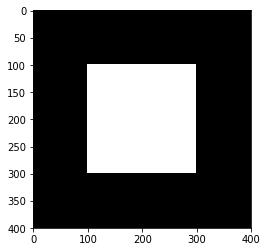

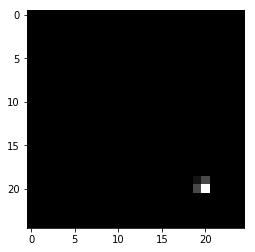

(11, 11)


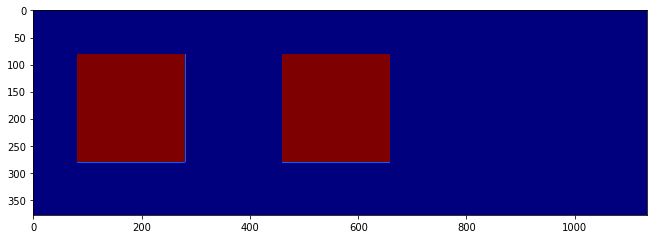

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


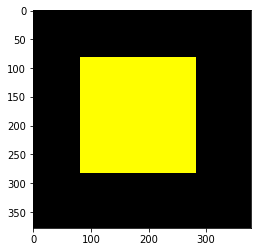

In [106]:
def get_error(im1,im2):
    e = ((im1-im2)**2).sum()#/(im1.shape[0]*im1.shape[1])    
    return e

#image = cv2.imread('./lena.jpg',cv2.IMREAD_GRAYSCALE).astype(np.uint8)

image = np.zeros((400,400))
image[100:-100,100:-100] = 255
#for ky in range(400):
#    for kx in range(400):
#        val = (ky-200)**2+(kx-200)**2
#        if val > 100**2:
#            image[ky,kx] = 255


h,w = image.shape

plt.imshow(image,cmap='gray')
plt.show()

theta = -7*np.pi/4

x = 11+11*np.cos(theta)
y = 11+11*np.sin(theta)
I1 = imbilinear(image,w-22,x,h-22,y)


kernel = weight_matrix_bilin(11,theta,val = 0)
plt.imshow(kernel,cmap='gray')
plt.show()

I2 = correlate(image,kernel)

#Find optmal shift
h2,w2 = I2.shape
h1,w1 = I1.shape

dh = h2-h1
dw = w2-w1

shift = []
for k in range(dh):
    for kk in range(dw):
        shift.append((k,kk))

errors = Parallel(n_jobs=16)(delayed(get_error)(I2[s[0]:s[0]+h1,s[1]:s[1]+w1],I1)
                            for s in shift)

errors = np.array(errors)
idx = np.argmin(errors)
print(shift[idx])

I2 = I2[shift[idx][0]:shift[idx][0]+h1,shift[idx][1]:shift[idx][1]+w1]

DI = np.abs(I1-I2)

ims = np.concatenate((I1,I2,DI),1)

plt.figure(figsize=(11,20))
plt.imshow(ims,cmap='jet')
plt.show()

I_ = np.concatenate((I1.reshape(h1,w1,1),I2.reshape(h1,w1,1),0*DI.reshape(h1,w1,1)),2)
plt.imshow(I_)
plt.show()

0.0
[3.0, 3.0, 2.0, 2.0]


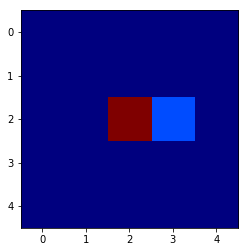

-0.25
[2.0, 3.0, 1.0, 2.0]


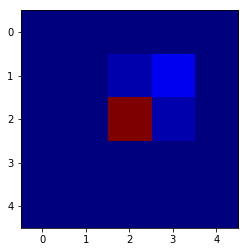

-0.5
[2.0, 2.0, 1.0, 1.0]


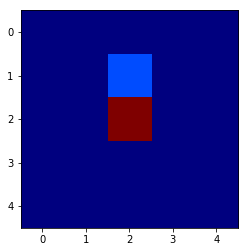

-0.75
[1.0, 2.0, 1.0, 2.0]


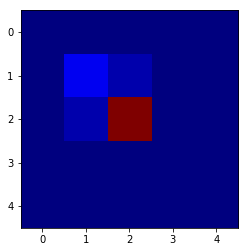

-1.0
[1.0, 1.0, 1.0, 2.0]


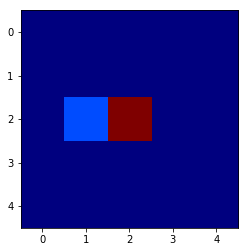

-1.25
[1.0, 2.0, 2.0, 3.0]


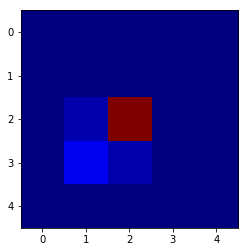

-1.5
[1.0, 2.0, 3.0, 3.0]


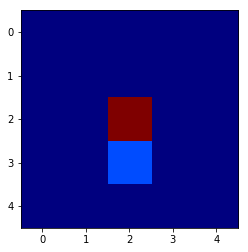

-1.75
[2.0, 3.0, 2.0, 3.0]


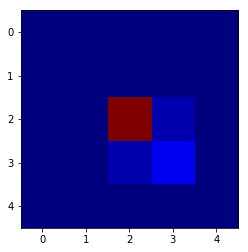

In [102]:
for k in range(0,-8,-1):
    theta = k*np.pi/4
    print(theta/np.pi)
    
    kernel = weight_matrix_bilin(1,theta,val = 5)
    
    #print(kernel)
    plt.imshow(kernel,cmap='jet')
    plt.show()
    

In [67]:
A = np.array([[1,2],[3,4]])
K = np.array([[1,0],[-1,0]])

a1 = correlate(A,K)
a2 = convolve(A,K)

print(a1)
print(a2)

[[ 0  0]
 [-2 -2]]
[[2 2]
 [0 0]]


In [32]:
#Gaussian kernel
def Gauss2D(w,sigma):
    #Generates 2d gaussian kernel
    kernel = np.zeros((w,w))
    #Constant for centering
    r = (w-1)/2
    for ii in range(w):
        for jj in range(w):
            x = -((ii-r)**2+(jj-r)**2)/(2*sigma**2)
            kernel[ii,jj] = np.exp(x)
    #Normalizing the kernel
    kernel = 1/np.sum(kernel)*kernel
    return kernel

#Local grayscale standardization
def localstandard(im,w1,w2,sigma1,sigma2):
    #Centers grayscales with Gaussian weighted mean
    #Gaussian kernels
    kernel1 = Gauss2D(w1,sigma1)
    kernel2 = Gauss2D(w2,sigma2)
    #Blurring
    blurred1 = convolve(im,kernel1)
    #Centering grayscale values
    centered = im-blurred1
    #Standardization
    std = (convolve(centered**2,kernel2))**0.5
    new_im = centered/(std+1e-09)
    return new_im

def make_2d_gauss(ks,sigma):
    #Mean indices
    c = ks//2
    
    #Exponents
    x = (np.linspace(0,ks-1,ks)-c)**2
    y = (np.linspace(0,ks-1,ks)-c)**2
    
    #Evaluate exponential functions
    ex = np.exp(-0.5*x/sigma**2)
    ey = np.exp(-0.5*y/sigma**2)
    
    #Iterate over kernel size
    kernel = np.zeros((ks,ks))
    for k in range(ks):
        kernel[k,:] = ey[k]*ex
    
    #Normalize so kernel sums to 1
    kernel /= kernel.sum()
    
    return kernel

def local_normalize(image,ks1,sigma1,ks2,sigma2 ):
    #Generate gaussian kernel
    kernel1 = make_2d_gauss(ks1,sigma1)
    kernel2 = make_2d_gauss(ks2,sigma2)
    
    mu = correlate(image,kernel1)
    
    centered = image-mu
    
    sd = correlate(centered**2,kernel2)**0.5
    
    return centered/(sd+1e-9)

In [43]:
def MRELBP(im,N,R,r,w_c,w_r):
    #Takes Median Robust Extended Local Binary Pattern from image im
    #Uses N neighbours from radii R and r, R must be larger than r
    #Median filter uses kernel sizes w_c for center pixels, w_r[0] for larger radius and w_r[1]
    #for smaller radius	
    #Grayscale values are centered at their mean and scales with global standad deviation

    #Mean grayscale value and std
    muI = im.mean()
    stdI = im.std()

    #Centering and scaling with std
    I = (im-muI)/stdI

    #Median filtering
    Ic = medfilt2d(I,w_c)
    #Center pixels
    d = round(R+(w_r[0]-1)/2)
    Ic = Ic[d:-d,d:-d]
    #Subtracting the mean pixel value from center pixels
    Ic = Ic-I.mean()
    #Bining center pixels
    Chist = np.zeros((1,2))
    Chist[0,0] = np.sum(Ic>=0)
    Chist[0,1] = np.sum(Ic<0)

    #Median filtered images for large and small radius
    IL = medfilt2d(I,w_r[0])
    d1 = round((w_r[0]-1)/2)
    IL = IL[d1:-d1,d1:-d1]
    IS = medfilt2d(I,w_r[1])
    d2 = round((w_r[1]-1)/2)
    IS = IS[d2:-d2,d2:-d2]
    
    #Neighbours
    pi = np.pi
    #Empty arrays for the neighbours
    row,col = np.shape(Ic)
    NL = np.zeros((row,col,N))
    NS = np.zeros((row,col,N))
    for k in range(N):
        #Angle to the neighbour
        theta = 0+k*(-1*2*pi/N)
        print("MRELBP: {0}".format(theta))
        #Large neighbourhood
        x = R+R*np.cos(theta)
        y = R+R*np.sin(theta)
        print(np.floor(x),np.floor(y))
        if abs(x-round(x)) < 1e-06 and abs(y-round(y)) < 1e-06:
            x = int(round(x))
            y = int(round(y))
            P = IL[y:y+row,x:x+col]
        else:
            P = imbilinear(IL,col,x,row,y)
        NL[:,:,k] = P
        #Small neighbourhood
        x = r+r*np.cos(theta)
        y = r+r*np.sin(theta)
        if abs(x-round(x)) < 1e-06 and abs(y-round(y)) < 1e-06:
            x = int(round(x))
            y = int(round(y))
            P = IS[y:y+row,x:x+col]
        else:
            P = imbilinear(IS,col,x,row,y)
        NS[:,:,k] = P
    #Thresholding

    #Thresholding radial neighbourhood
    NR = NL-NS
    
    return NL,NS,NR

def Conv_MRELBP(image,N,R,r,wR,wr,wc):
    #Whiten the image
    imu = image.mean()
    istd = image.std()
    im = (image-imu)/istd
    #Get image dimensions
    h,w = im.shape[:2]
    #Make kernels
    kR = []
    kr = []
    dtheta = np.pi*2/N
    for k in range(0,-N,-1):
        print("Conv_MRELBP: {0}".format(k*dtheta))
        _kernel = weight_matrix_bilin(R,k*dtheta,0)
        kR.append(_kernel)
        
        _kernel = weight_matrix_bilin(r,k*dtheta,0)
        kr.append(_kernel)
        
    #Make median filtered images
    imc = medfilt2d(im,wc)
    imR = medfilt2d(im,wR)
    imr = medfilt2d(im,wr)
    
        #Get LBP images
    neighbR = np.zeros((h,w,N))
    neighbr = np.zeros((h,w,N))
    for k in range(N):
        _neighb = correlate(imR,kR[k])
        neighbR[:,:,k] = _neighb
        _neighb = correlate(imr,kr[k])
        neighbr[:,:,k] = _neighb
    
    
    #Crop valid convolution region
    d = R+wR//2
    h -=2*d
    w -=2*d
    
    
    neighbR = neighbR[d:-d,d:-d,:]
    neighbr = neighbr[d:-d,d:-d,:]
    imc = imc[d:-d,d:-d]
    
    '''
    #Subtraction
    _muR = neighbR.mean(2).reshape(h,w,1)
    for k in range(N):
        try:
            muR = np.concatenate((muR,_muR),2)
        except NameError:
            muR = _muR
            
    _mur = neighbr.mean(2).reshape(h,w,1)
    for k in range(N):
        try:
            mur = np.concatenate((mur,_mur),2)
        except NameError:
            mur = _mur
            
    diffc = ((imc-imc.mean())>=0)*1.0
    diffR = ((neighbR-muR)>=0)*1.0
    diffr = ((neighbr-mur)>=0)*1.0
    diffR_r = ((neighbR-neighbr)>=0)*1.0
    '''
    return neighbR,neighbr,neighbR-neighbr

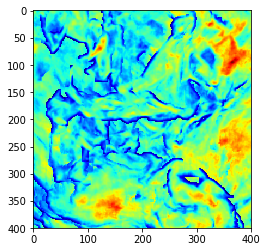

In [44]:
path = './cartvoi_surf_new/13_R3L__surf.h5'
h5 = h5py.File(path,'r')
image = h5['sum'][:]
h5.close()

plt.imshow(image,cmap='jet')
plt.show()

6.929606586166365e-25


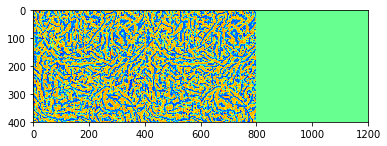

In [45]:
#Normalization test
n1 = localstandard(image,23,5,5,1)
n2 = local_normalize(image,23,5,5,1)

I = np.concatenate((n1,n2,(n1-n2)**2),1)
print(np.sum((n1-n2)**2))
plt.imshow(I,cmap='jet')
plt.show()

In [46]:
ims1 = MRELBP(image,8,9,3,5,(5,5))
ims2 = Conv_MRELBP(image,8,9,3,5,5,5)

MRELBP: 0.0
18.0 9.0
MRELBP: -0.7853981633974483
15.0 2.0
MRELBP: -1.5707963267948966
9.0 0.0
MRELBP: -2.356194490192345
2.0 2.0
MRELBP: -3.141592653589793
0.0 8.0
MRELBP: -3.9269908169872414
2.0 15.0
MRELBP: -4.71238898038469
8.0 18.0
MRELBP: -5.497787143782138
15.0 15.0
Conv_MRELBP: 0.0
Conv_MRELBP: -0.7853981633974483
Conv_MRELBP: -1.5707963267948966
Conv_MRELBP: -2.356194490192345
Conv_MRELBP: -3.141592653589793
Conv_MRELBP: -3.9269908169872414
Conv_MRELBP: -4.71238898038469
Conv_MRELBP: -5.497787143782138


[378, 378, 8]
[0.0, 0.0, 0.0]


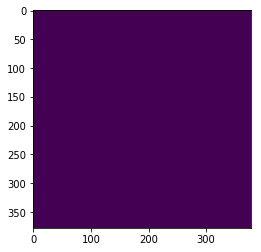

[0.9723936198677613, -1.0084514552422406, -119.32031211104848]


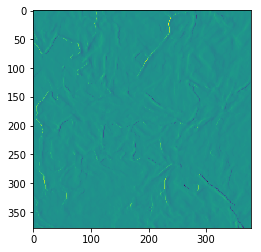

[0.0, 0.0, 0.0]


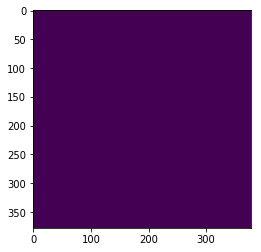

[1.0084527753603152, -0.9723915213499217, 121.29233294749346]


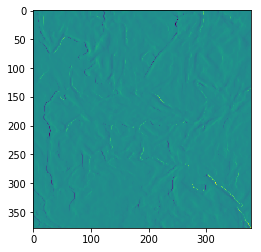

[3.289804138003541, -3.9102747144344656, 60.97442313920769]


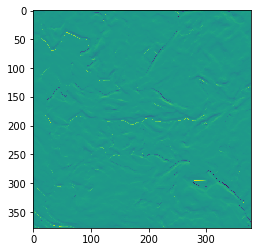

[1.0162580010863855, -0.974147775093892, 119.95595886231166]


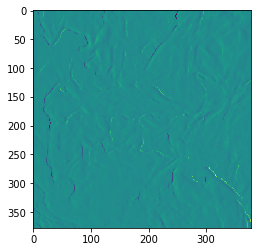

[3.8860918045889, -3.595049337194748, 484.4628430482974]


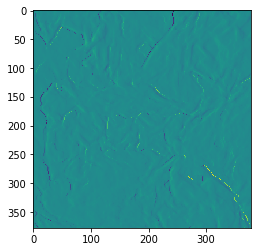

[0.9741498957714757, -1.0162566309765457, -123.69867803697778]


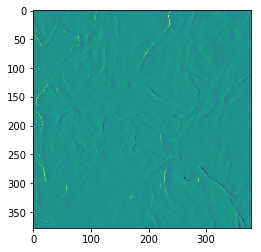

[378, 378, 8]
[3.919708810049615, -4.195850662547589, -3179.295571440605]


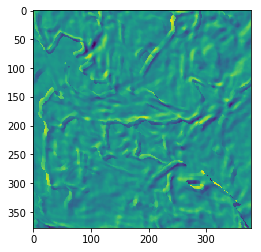

[3.7252111140684825, -4.298326049630858, -3578.6790902685084]


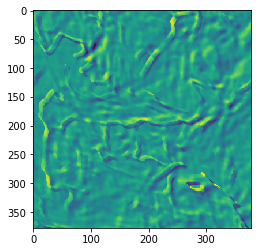

[3.919708810049615, -4.195850662547589, -3178.423553526913]


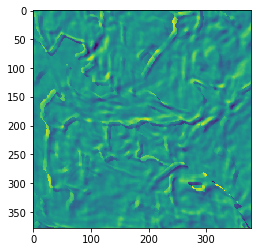

[3.7585449423293147, -3.9838676657759438, -2730.9959731872113]


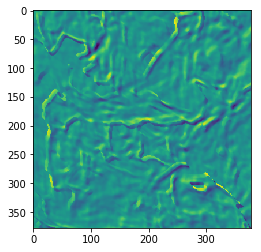

[3.7223172145115355, -4.133501411414761, -2935.4109443210696]


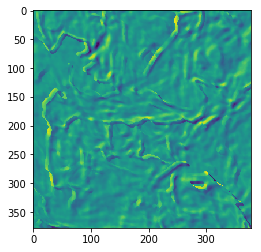

[3.7231006589993214, -3.987866361486067, -2709.942047772012]


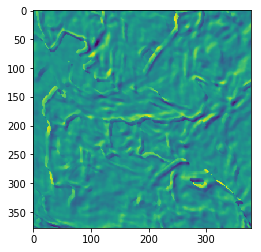

[3.9879868370666864, -3.971064958666176, -2670.2007517291013]


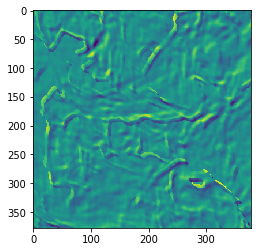

[3.7248197133907026, -4.311179881194194, -3540.2080766065374]


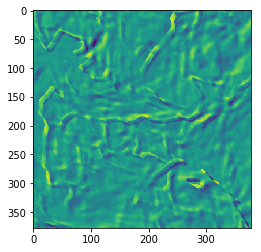

[378, 378, 8]
[4.195850662547588, -3.919708810049615, 3179.295571440605]


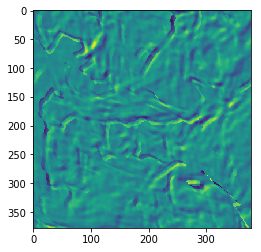

[4.323709286657946, -3.725213468264271, 3459.35877815746]


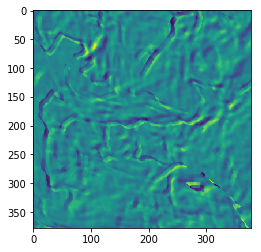

[4.195850662547589, -3.919708810049615, 3178.423553526913]


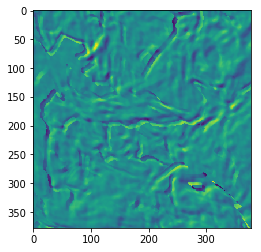

[4.206393511176049, -4.400524666865239, 2852.288306134704]


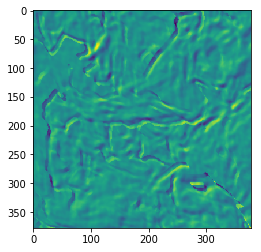

[5.344988410149441, -5.665125712910994, 2996.385367460277]


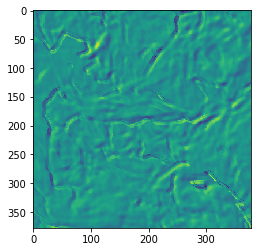

[4.02485184816682, -4.230434385746555, 2829.8980066343242]


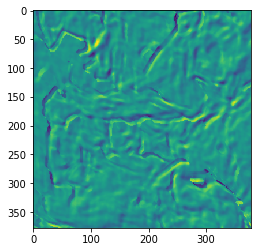

[5.631341244785659, -6.3080922951944025, 3154.663594777399]


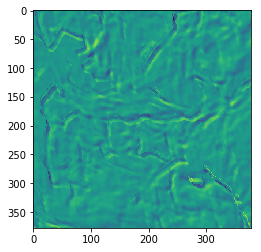

[4.358384809361408, -3.888597577406932, 3416.5093985695594]


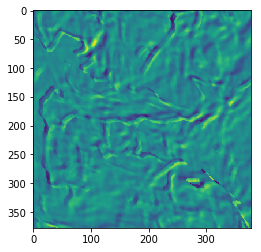

In [32]:
for i1,i2 in zip(ims1,ims2):
    d = (i1-i2)
    row,col,plane = d.shape
    print([row,col,plane])
    for k in range(plane):
        I = d[:,:,k]
        print([I.max(),I.min(),I.sum()])
        plt.imshow(I)
        plt.show()
    